# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

***Дополнительные условия:***

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).  
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
Бюджет на разработку скважин в регионе — 10 млрд рублей.  
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.


***Описание данных***

Признаки:

    id — уникальный идентификатор скважины;
    f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

Целевой признак:

    product — объём запасов в скважине (тыс. баррелей).

***Последовательность выполнения проекта:***

1. Загрузим и подготовим данные.  
2. Обучим и проверим модель для каждого региона:   
    2.1. Разобьём данные на обучающую и валидационную выборки в соотношении 75:25.  
    2.2. Обучим модель и сделаем предсказания на валидационной выборке.  
    2.3. Сохраним предсказания и правильные ответы на валидационной выборке.  
    2.4. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.  
    2.5. Проанализируем результаты.  
3. Подготовимся к расчёту прибыли:  
    3.1. Все ключевые значения для расчётов сохраним в отдельных переменных.  
    3.2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.  
    3.3. Напишем выводы по этапу подготовки расчёта прибыли.  
4. Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:  
    4.1. Выберем скважины с максимальными значениями предсказаний.  
    4.2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.  
    4.3. Рассчитаем прибыль для полученного объёма сырья.  
5. Посчитаем риски и прибыль для каждого региона:  
    5.1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.  
    5.2. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.  
    5.3. Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.  

## Загрузка и подготовка данных

### Откроем и сохраним файл данных

Импортируем нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st

#import warnings
#warnings.filterwarnings('ignore')

In [2]:
# Открываем и сохраняем файлы данных геологоразведки трёх регионов geo_data_0.csv, geo_data_1.csv и geo_data_0.csv
# в датафреймы из директории или по ссылке:

try:
    geo_df_1 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_df_2 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_df_3 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    geo_df_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    geo_df_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    geo_df_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

***Датафрейм данными геологоразветки 1-го региона***

In [3]:
# Посмотрим полную информацию датафрейма df_users:
geo_df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
# Выведем первые пять строк датафрейма df_subs:
geo_df_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


В датасете `geo_df_1` 5 столбцов и 10000 записей. Датасет содержит характеристики скважин региона:
   - id — уникальный идентификатор скважины;
   - f0, f1, f2 — три признака качества невти (неважно, что они означают, но сами признаки значимы);
   - product — объём запасов в скважине (тыс. баррелей).  
   
Столбцы датафрейма имеют тип object и float64. Пропусков нет.

***Датафрейм данными геологоразветки 2-го региона***

In [5]:
# Посмотрим полную информацию датафрейма df_users:
geo_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
# Выведем первые пять строк датафрейма df_subs:
geo_df_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


В датасете `geo_df_2` 5 столбцов и 10000 записей. Датасет содержит характеристики скважин региона:
   - id — уникальный идентификатор скважины;
   - f0, f1, f2 — три признака качества нефти (неважно, что они означают, но сами признаки значимы);
   - product — объём запасов в скважине (тыс. баррелей).  
   
Столбцы датафрейма имеют тип object и float64. Пропусков нет.

***Датафрейм данными геологоразветки 3-го региона***

In [7]:
# Посмотрим полную информацию датафрейма df_users:
geo_df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
# Выведем первые пять строк датафрейма df_subs:
geo_df_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


В датасете `geo_df_3` 5 столбцов и 10000 записей. Датасет содержит характеристики скважин региона:
   - id — уникальный идентификатор скважины;
   - f0, f1, f2 — три признака качества невти (неважно, что они означают, но сами признаки значимы);
   - product — объём запасов в скважине (тыс. баррелей).  
   
Столбцы датафрейма имеют тип object и float64. Пропусков нет.

### Предобработка данных

Проверим датафреймы на явные дубликаты

In [9]:
reg = 1
for dataset in [geo_df_1, geo_df_2, geo_df_3]:
    print('Для региона', reg, ':')
    print('Кол-во дубликатов =', dataset.duplicated().sum())
    reg += 1

Для региона 1 :
Кол-во дубликатов = 0
Для региона 2 :
Кол-во дубликатов = 0
Для региона 3 :
Кол-во дубликатов = 0


Явных дубликатов нет

Проверим, есть ли дубликаты по id и какие:

In [10]:
for dataset in [geo_df_1, geo_df_2, geo_df_3]:
    print('Кол-во дубликатов по id =', dataset.id.duplicated().sum())
    display(dataset[dataset.id.duplicated(keep=False)].sort_values(by='id'))
    print()

Кол-во дубликатов по id = 10


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502



Кол-во дубликатов по id = 4


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305



Кол-во дубликатов по id = 4


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


В  трех датасетах 18 дубликатов (10, 4, 4 - соответственно) - удаляем, оставив скважины с наибольшим из дубликатов значением `product`. На качество модели удаление такого небольшого количества данных повлиять не должно.

In [11]:
geo_df_1.drop(labels=[66136, 51970, 69163, 931, 63593, 75715, 60140, 97785, 1364, 16633],
                axis=0,
                inplace=True)

geo_df_2.drop(labels=[5849, 41906, 82178, 47591],
                axis=0,
                inplace=True)

geo_df_3.drop(labels=[45404, 49564, 95090, 28039],
                axis=0,
                inplace=True)

In [12]:
# Проверяем:
for dataset in [geo_df_1, geo_df_2, geo_df_3]:
    print('Кол-во дубликатов по id =', dataset.id.duplicated().sum())
    display(dataset[dataset.id.duplicated(keep=False)].sort_values(by='id'))
    print()

Кол-во дубликатов по id = 0


,id,f0,f1,f2,product



Кол-во дубликатов по id = 0


,id,f0,f1,f2,product



Кол-во дубликатов по id = 0


,id,f0,f1,f2,product


Столбец `id` не несет значимости для для модели, поэтому удаляем его, предварительно сделав словарем:

In [13]:
dict_1 = geo_df_1[['id']].to_dict('index')
dict_2 = geo_df_2[['id']].to_dict('index')
dict_3 = geo_df_3[['id']].to_dict('index')

In [14]:
# Удаляем и проверяем:
for dataset in [geo_df_1, geo_df_2, geo_df_3]:
    dataset.drop(columns=['id'],axis=1, inplace=True)
    display(dataset)

,f0,f1,f2,product
0,0.705745,-0.497823,1.221170,105.280062
1,1.334711,-0.340164,4.365080,73.037750
2,1.022732,0.151990,1.419926,85.265647
3,-0.032172,0.139033,2.978566,168.620776
4,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...
99995,0.971957,0.370953,6.075346,110.744026
99996,1.392429,-0.382606,1.273912,122.346843
99997,1.029585,0.018787,-1.348308,64.375443
99998,0.998163,-0.528582,1.583869,74.040764


,f0,f1,f2,product
0,-15.001348,-8.276000,-0.005876,3.179103
1,14.272088,-3.475083,0.999183,26.953261
2,6.263187,-5.948386,5.001160,134.766305
3,-13.081196,-11.506057,4.999415,137.945408
4,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...
99995,9.535637,-6.878139,1.998296,53.906522
99996,-10.160631,-12.558096,5.005581,137.945408
99997,-7.378891,-3.084104,4.998651,137.945408
99998,0.665714,-6.152593,1.000146,30.132364


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673
1,0.262778,0.269839,-2.530187,56.069697
2,0.194587,0.289035,-5.586433,62.871910
3,2.236060,-0.553760,0.930038,114.572842
4,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...
99995,-1.777037,1.125220,6.263374,172.327046
99996,-1.261523,-0.894828,2.524545,138.748846
99997,-1.199934,-2.957637,5.219411,157.080080
99998,-2.419896,2.417221,-5.548444,51.795253


### Корреляцию данных

***Датафрейм данными геологоразветки 1-го региона***

In [15]:
# Выведем сводную статистику по столбцам:
geo_df_1.describe()

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500439,0.250140,2.502740,92.501735
std,0.871857,0.504433,3.248177,44.288557
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072595,-0.200882,0.287887,56.497903
50%,0.502374,0.250252,2.516005,91.853150
75%,1.073626,0.700640,4.715035,128.564492
max,2.362331,1.343769,16.003790,185.364347


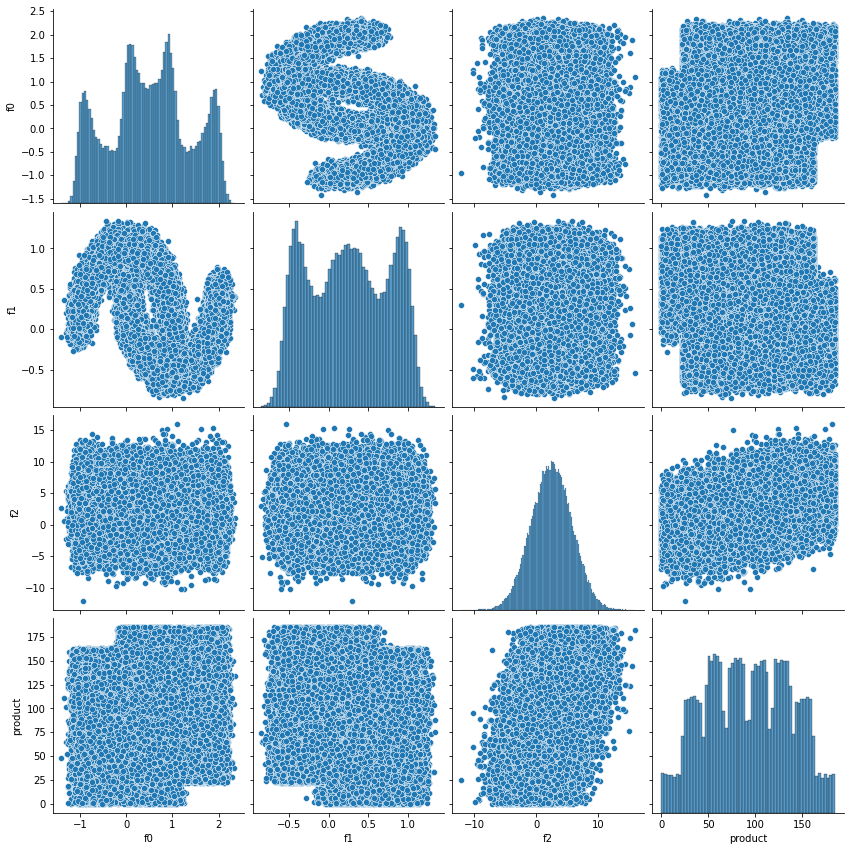

In [16]:
sns.pairplot(geo_df_1, height=3, markers=['o', 'D']);

In [17]:
geo_df_1.corr()

,f0,f1,f2,product
f0,1.000000,-0.440730,-0.003203,0.143508
f1,-0.440730,1.000000,0.001760,-0.192346
f2,-0.003203,0.001760,1.000000,0.483662
product,0.143508,-0.192346,0.483662,1.000000


**Вывод:** по графикам отчётливо видна симметричность и, как причина, синтетичность данных. Нет явно выбивающихся значений. Матрицы корреляции Пирсона показывают высокую зависимость показателя объёма запасов нефти от признака f2.

***Датафрейм данными геологоразветки 2-го региона***

In [18]:
# Выведем сводную статистику по столбцам:
geo_df_2.describe()

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141619,-4.796476,2.494571,68.825739
std,8.965953,5.119908,1.703585,45.944818
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298525,-8.267985,1.000021,26.953261
50%,1.153350,-4.813005,2.011480,57.085625
75%,8.621076,-1.332704,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


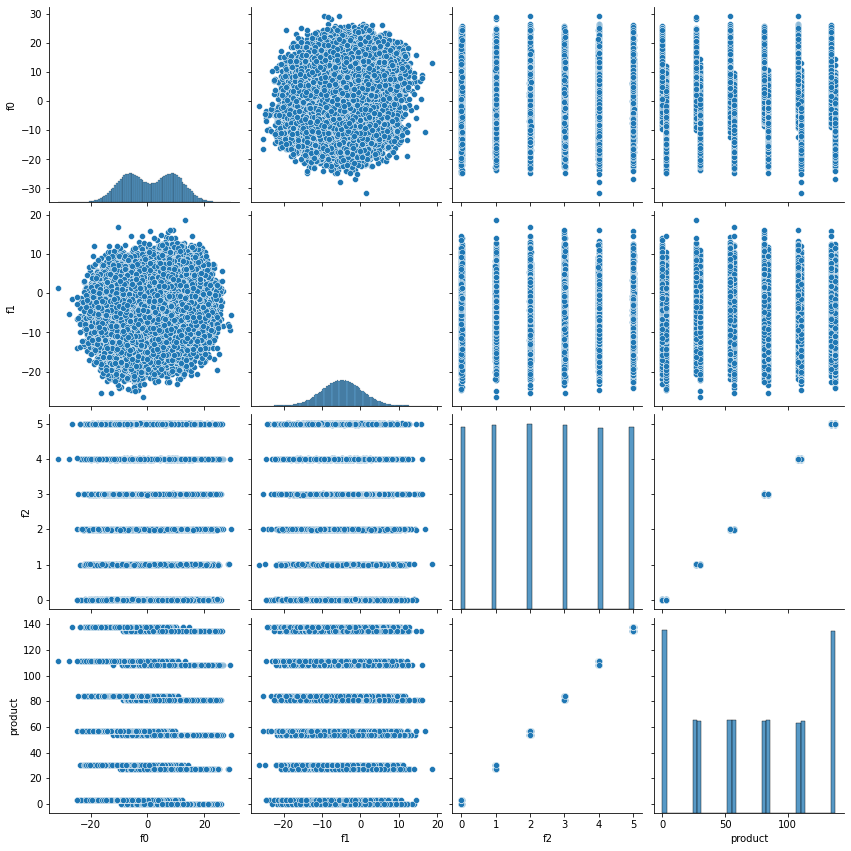

In [19]:
sns.pairplot(geo_df_2, height=3, markers=['o', 'D']);

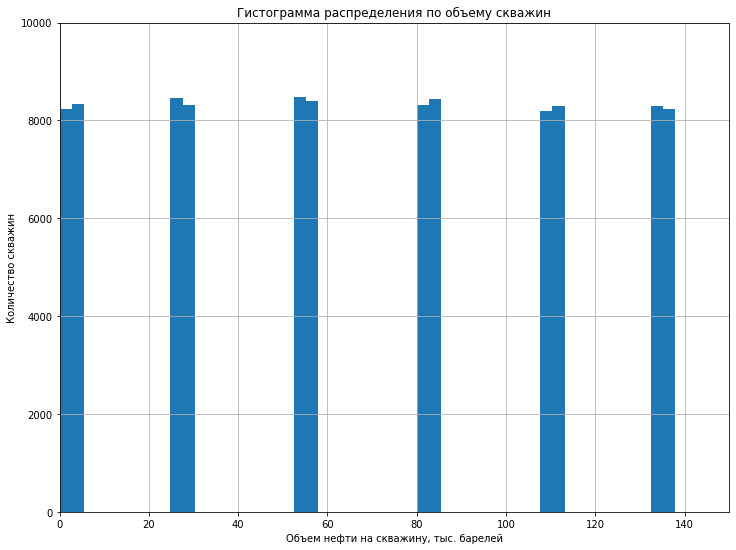

In [20]:
# Приблизим гистограмму по столбцу product:
geo_df_2.hist(['product'], bins=50, figsize=[12,9])

plt.xlim([0,150])
plt.ylim([0,10000])

plt.xlabel("Объем нефти на скважину, тыс. барелей")
plt.ylabel("Количество скважин")

plt.title("Гистограмма распределения по объему скважин");

In [21]:
geo_df_2.corr()

,f0,f1,f2,product
f0,1.000000,0.182278,-0.001796,-0.030509
f1,0.182278,1.000000,-0.002609,-0.010168
f2,-0.001796,-0.002609,1.000000,0.999397
product,-0.030509,-0.010168,0.999397,1.000000


**Вывод:** по графикам отчётливо видна симметричность и, как причина, синтетичность данных. Данные имеют странное распределение: от 0 до 5 баррелей с шагом по 15-20 равномерно распределены 100000 значений. Данные не подчиняются закону больших чисел и скорей всего были введены искуственно.. Матрица корреляции Пирсона показывает прямую и линейную зависимость показателя объёма запасов нефти от признака f2. 

***Датафрейм данными геологоразветки 3-го региона***

In [22]:
# Выведем сводную статистику по столбцам:
geo_df_3.describe()

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,0.001987,-0.002093,2.495169,95.001336
std,1.732050,1.730431,3.473466,44.748968
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174820,0.130359,59.452094
50%,0.009411,-0.009580,2.484256,94.925994
75%,1.158477,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


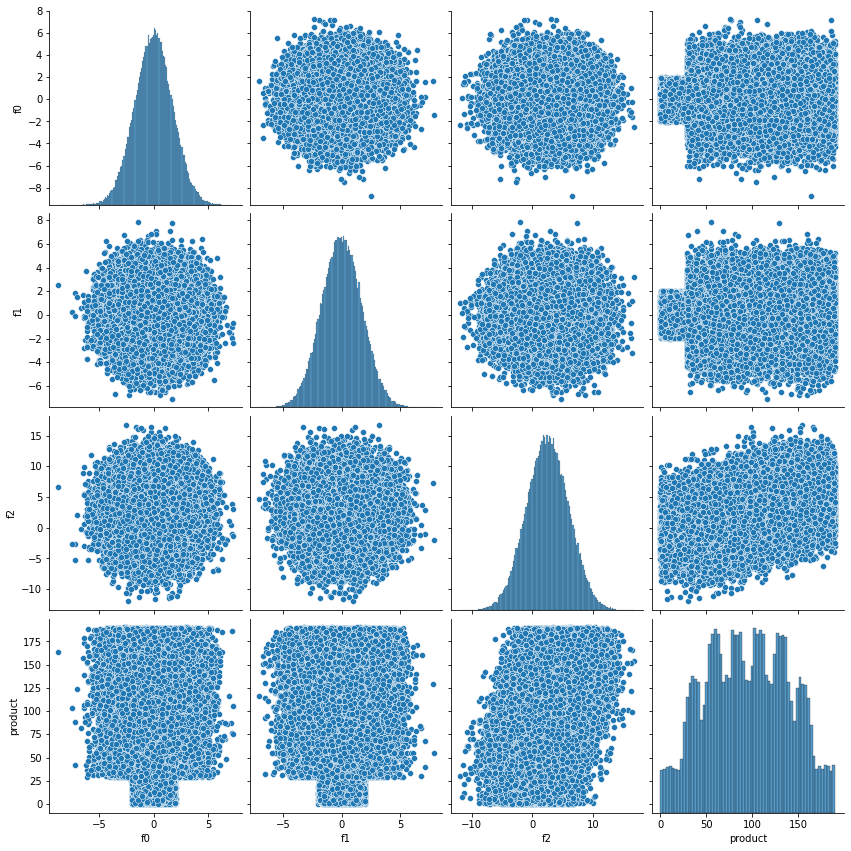

In [23]:
sns.pairplot(geo_df_3, height=3, markers=['o', 'D']);

In [24]:
geo_df_3.corr()

,f0,f1,f2,product
f0,1.000000,0.000512,-0.000438,-0.001960
f1,0.000512,1.000000,0.000790,-0.001029
f2,-0.000438,0.000790,1.000000,0.445886
product,-0.001960,-0.001029,0.445886,1.000000


**Вывод:** по графикам отчётливо видна симметричность и, как причина, синтетичность данных. Нет явно выбивающихся значений. Матрицы корреляции Пирсона показывают высокую зависимость показателя объёма запасов нефти от признака f2.

### Вывод: 
В таблицах пропусков нет. Явных дубликатов нет. От неявных избавились (всего 18 дубликатов на три датасета) Типы данных преобразовывать не надо. Столбец id удалили, предварительно сделав словарем, чтобы сохранить обозначение скважины и чтобы убрать данные типа object из дальнейшего анализа.
Наибольшее влияние на целевой признак оказывает признак f2. Остальные признаки влияют менее значимо или обратно пропорционально.
Данных достаточно для дальнейшего анализа.

## Обучение и проверка модели

### Обучим и проверим модель для каждого региона:

   - разобьём данные на обучающую и валидационную выборки в соотношении 75:25;
   - масштабируем признаки методом стандартизации;
   - обучим модель;
   - сделаем предсказания на валидационной выборке;
   - выведем результаты по регионам:  
       - Средний предсказанный запас сырья  
       - Средний реальный запас сырья  
       - Разница между реальным и предсказанным запасами сырья  
       - RMSE на валидационной выборке модели

In [25]:
# Скопируем датафреймы до работы с ними:
geo_1 = geo_df_1.copy()
geo_2 = geo_df_2.copy()
geo_3 = geo_df_3.copy()

In [26]:
# предотвращение появления предупреждающего сообщения SettingWithCopy:
pd.options.mode.chained_assignment = None

In [27]:
# Пройдем циклом по каждому датафрейму:
reg = 1
geo_all = [geo_1, geo_2, geo_3]

# Фиксируем численные признаки:
numeric = ['f0', 'f1', 'f2']


for dataset in geo_all:
    
#извлекаю признаки и целевой признак:
    features = dataset.drop(['product'], axis=1)
    target = dataset['product']
    
# Разбиваем данные на обучающую и валидационную выборки в соотношении 75:25:
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)
    
# Создаем объект для стандартизации данных::    
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
# Масштабирование обучающего набора данных:
    features_train[numeric] = scaler.transform(features_train[numeric])
# Масштабирование валидационного набора данных:
    features_valid[numeric] = scaler.transform(features_valid[numeric])

# Обучаем модель на маштабированных данных и выводим среднеквадратичную ошибку: 
    model = LinearRegression() 
    model.fit(features_train, target_train) 
    predictions_valid = model.predict(features_valid)

    rmse = mean_squared_error(target_valid, predictions_valid)**0.5
    
    print('Для региона', reg, ':')
    print('Средний предсказанный запас сырья =', round(target_valid.mean(), 3), 'тыс.бар.')
    print('Средний реальный запас сырья = ', round(target.mean(),3), 'тыс.бар.')
    print('Разница между реальным и предсказанным запасами сырья =', round(target.mean() - target_valid.mean(), 3), 'тыс.бар.')
    print('RMSE на валидационной выборке =', round(rmse, 3))
    print()
    reg += 1

Для региона 1 :
Средний предсказанный запас сырья = 92.468 тыс.бар.
Средний реальный запас сырья =  92.502 тыс.бар.
Разница между реальным и предсказанным запасами сырья = 0.034 тыс.бар.
RMSE на валидационной выборке = 37.667

Для региона 2 :
Средний предсказанный запас сырья = 68.442 тыс.бар.
Средний реальный запас сырья =  68.826 тыс.бар.
Разница между реальным и предсказанным запасами сырья = 0.384 тыс.бар.
RMSE на валидационной выборке = 0.891

Для региона 3 :
Средний предсказанный запас сырья = 94.759 тыс.бар.
Средний реальный запас сырья =  95.001 тыс.бар.
Разница между реальным и предсказанным запасами сырья = 0.242 тыс.бар.
RMSE на валидационной выборке = 40.172



### Вывод:

Разбили данные по каждому региону на тренировочную и валидационные выборки. Отмасштабировали признаки методом стандартизации данных и обучили модель линейной регрессии.  
Наименьшая среднеквадратичная ошибка - RMSE - у модель 2-го регионе (признак f2 показал прямую корреляцию с целевым значением). Разницы с фактическими значениями нет, RMSE составила всего 0,891 тыс. баррелей.  
Разница между реальным и предсказанным запасами сырья лучше всего в 1 регионе - 0,034 тыс. баррелей. Наибольшая RMSE во 3 регионе - 40,172 тыс. баррелей.

## Подготовка к расчёту прибыли

Сохраним ключевые значения для расчётов в отдельных переменных.

In [28]:
WELLS = 200                 # 200 лучших точек для разработки
CHOSEN_POINTS = 500         # исследуем 500 точек
BUDGET = 10000              # бюджет на разработку скважин в регионе — 10 млрд рублей, млн.руб.
PRICE_PER_BARREL = 0.45     # тысяча баррелей сырья приносит 450 тыс рублей дохода, млн.руб.

In [29]:
oil_for_well = BUDGET / PRICE_PER_BARREL / WELLS 
print('Достаточный объём сырья для безубыточной разработки новой скважины =', round(oil_for_well, 3), 'тыс.бар.')

Достаточный объём сырья для безубыточной разработки новой скважины = 111.111 тыс.бар.


Для региона 1 :
Средний реальный запас сырья =  92.502 тыс.бар.

Для региона 2 :
Средний реальный запас сырья =  68.826 тыс.бар.

Для региона 3 :
Средний реальный запас сырья =  95.001 тыс.бар.

***Вывод***  
Достаточный объём сырья для безубыточной разработки новой скважины =  111.1 тысяч баррелей нефти. Средние объемы в скважинах всех месторождений ниже этой отметки. Необходимо выбрать наиболее выгодные точки в каждом месторождении и уже их сравнивать между собой.

## Расчёт прибыли и рисков 

### Расчет средней прибыли и рисков

Выбираем самое прибильное месторождение исходя из ограничей, установленных бизнес-задачей. 
Для этого поготовим функцию расчета прибыли, где на основе предсказаний (target, probabilities), доходов (revenue) и кол-ва скважин (count) считается прибыль:

In [30]:
def profit_calc(target, probabilities, revenue, count):
    #сортируем предсказания по скважинам по убыванию
    probs_sorted = probabilities.sort_values(ascending=False)
    #отбираем срезом до count индексы скважин с максимальными значениями предсказаний
    selected = target[probs_sorted.index][:count]
    # возвращаем -  прибыль = доход * скважины с максимальными значениями предсказаний - бюджет на разработку скважин в регионе
    return PRICE_PER_BARREL * selected.sum() - BUDGET

In [31]:
reg = 1
geo_all = [geo_1, geo_2, geo_3]

numeric = ['f0', 'f1', 'f2']


for dataset in geo_all:
    features = dataset.drop(['product'], axis=1)
    target = dataset['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size=0.25,
                                                                                  random_state=12345)    
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])

    model = LinearRegression() 
    model.fit(features_train, target_train) 
    predictions_valid = model.predict(features_valid)
    
    predictions_valid_ = pd.Series(predictions_valid) #перевожу массив предсказаний в pd.Series                                                
    target_valid_ = pd.Series(target_valid).reset_index(drop=True)  #перевожу целевой признак в pd.Series
    
# Функция для применения техники Bootstrap с 1000 выборокам:
    state = np.random.RandomState(12345)
    
    values = []
    
    
    for i in range(1000):
        target_subsample = target_valid_.sample(n=CHOSEN_POINTS, replace=True, random_state=state) 
        probs_subsample = predictions_valid_[target_subsample.index]
        values.append(profit_calc(target_subsample, probs_subsample, PRICE_PER_BARREL, WELLS))

    values = pd.Series(values)

    mean = values.mean()
    lower = values.quantile(.025)
    upper = values.quantile(.975)
    risk = st.percentileofscore(values, 0)
    
    print('Для региона', reg, ':')
    print('Средняя прибыль =', round(mean, 3), 'млн.руб.')
    print('Доверительный интервал: [', round(lower,3), ':', round(upper,3), ']')
    print('Риск -', round (risk,2), '%')
    print()
    
    reg += 1

Для региона 1 :
Средняя прибыль = 461.698 млн.руб.
Доверительный интервал: [ -90.992 : 984.183 ]
Риск - 4.5 %

Для региона 2 :
Средняя прибыль = 466.844 млн.руб.
Доверительный интервал: [ 63.931 : 908.047 ]
Риск - 1.2 %

Для региона 3 :
Средняя прибыль = 373.863 млн.руб.
Доверительный интервал: [ -176.955 : 923.646 ]
Риск - 8.1 %



### ***Вывод*** 
Написали функцию для расчета прибыли по выбранным скважинам для вычисления прибыли полученного объема сырья. Применили технику `bootstrap` с 1000 выборок, чтобы найти распределение прибыли. Рассчитали среднюю прибыль и 95% доверительный интервал, а также риски убытков для каждого региона:

    - все три региона являются прибыльными по средней прибыли:  
            регион 1 - 461.698 млн.руб.
            регион 2 - 466.844 млн.руб.  
            регион 3 - 373.863 млн.руб.  
            Наибольшая средняя прибыль в регионе 2.
            
    - наибольшая потенциальная прибыль в регионе-1 984.183 млн. руб.
    - регионы 1 и 3 обладают большими рисками убытков (4.5% и 8.1% соответственно), чем регион 2 (1.2%). 
    Левая граница (2.5%) доверительного интервала (95%-ый) принимает отрицательные значения для первого и третьего региона. На основании изучения доверительного интервала региона 2 (весь интервал лежит в облости положительных значений) можно сделать вывод, что даже при не очень удачном выборе разработка скважин окупится.
   
 На основании проведенных расчетов и анализа данных трех регионов согласно критериям бизнес-задачи ( риски < 2.5%, наибольшая средняя прибыль), заказчику **для дальнейшей разработки рекомендуется принять 2-й регион**.

### Общий вывод:

- Загрузили и произвели подготовку данных по трем регионам.  
     - Каждый датасет содержит 5 столбцов по 10 000 записей.  
     - Пропусков нет. Явных дубликатов нет. От неявных избавились (всего 18 дубликатов на три датасета) Типы данных преобразовывать не надо. Столбец id удалили, предварительно сделав словарем, чтобы сохранить обозначение скважины и чтобы убрать данные типа object из дальнейшего анализа. Наибольшее влияние на целевой признак оказывает признак f2. Остальные признаки влияют менее значимо или обратно пропорционально. 
     - по графикам корреляции  для региона 2 было выявленно, что данные имеют странное распределение: от 0 до 5 баррелей с шагом по 15-20 равномерно распределены 100000 значений. Данные не подчиняются закону больших чисел и скорей всего были введены искуственно.. Матрица корреляции Пирсона показывает прямую и линейную зависимость показателя объёма запасов нефти от признака f2
- Разбили данные по каждому региону на тренировочную и валидационные выборки.  
    Отмасштабировали признаки методом стандартизации данных и обучили модель линейной регрессии.
    Наименьшая среднеквадратичная ошибка - RMSE - у модель 2-го регионе (признак f2 показал прямую корреляцию с целевым значением). Разницы с фактическими значениями нет, RMSE составила всего 0,891 тыс. баррелей.
    Разница между реальным и предсказанным запасами сырья лучше всего в 1 регионе - 0,034 тыс. баррелей. Наибольшая RMSE во 3 регионе - 40,172 тыс. баррелей. 
- Расчитали достаточный объём сырья для безубыточной разработки новой скважины =  111.1 тысяч баррелей нефти. Средние объемы в скважинах всех месторождений ниже этой отметки. Пришли к выводу о необходимости выбрать наиболее выгодные точки в каждом месторождении и уже их сравнивать между собой.
- Написали функцию для расчета прибыли по выбранным скважинам для вычисления прибыли полученного объема сырья. Применили технику bootstrap с 1000 выборок, чтобы найти распределение прибыли. Рассчитали среднюю прибыль и 95% доверительный интервал, а также риски убытков для каждого региона:

    - все три региона являются прибыльными по средней прибыли:  
        регион 1 - 461.698 млн.руб.  
        регион 2 - 466.844 млн.руб.  
        регион 3 - 373.863 млн.руб.  
        Наибольшая средняя прибыль в регионе 2.

    - наибольшая потенциальная прибыль в регионе-1 984.183 млн. руб.
    - регионы 1 и 3 обладают большими рисками убытков (4.5% и 8.1% соответственно), чем регион 2 (1.2%). Левая граница (2.5%) доверительный интервал (95%-ый) принимает отрицательные значения для первого и третьего региона. На основании изучения доверительного интервал региона 2 можно сделать вывод, что даже при не очень удачном выборе разработка скважин окупится.  



- На основании проведенных расчетов и анализа данных трех регионов согласно критериям бизнес-задачи ( риски < 2.5%, наибольшая средняя прибыль), заказчику ***для дальнейшей разработки рекомендуется принять 2-й регион***.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован